#***FYP-II***

#**FYP TITLE:** ***Identification of Neurological Diseases using Deep Learning Methods***

##***Team***


*   **Muhammad Tahir K214503 *(Leader)***
*   **Insha Javed K213279**
*   **Hasan Iqbal K213297**





**Import Libraries**

In [1]:
import os
import sys
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

lib_dir = "/content/drive/MyDrive/colab_libraries"
# os.makedirs(lib_dir, exist_ok=True)

# !pip install --target="{lib_dir}" numpy==1.24.3 pandas==2.0.1 scikit-learn==1.3.0 matplotlib==3.5.3 pytorch-tabnet==4.0 tensorflow==2.13.0 tqdm torch joblib tabulate

sys.path.append(lib_dir)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import requests
import warnings
import datetime
from tqdm import tqdm
from tabulate import tabulate
from pytorch_tabnet.tab_model import TabNetRegressor, TabNetClassifier
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')
np.seterr(all="ignore")

!pip install shap

print("Libraries successfully imported!")

Mounted at /content/drive
Libraries successfully imported!


Utils.py

In [ ]:
def load_data(file):
    data = pd.read_csv(file, sep=" ", header=0)
    data = data.iloc[:, 5:]
    return data.dropna(axis=1, how='all')

def impute_data(data, imputation_method):
    if imputation_method == 'simple':
        imputer = SimpleImputer(strategy='mean')
    elif imputation_method == '1nn':
        imputer = KNNImputer(n_neighbors=1)
    elif imputation_method == '5nn':
        imputer = KNNImputer(n_neighbors=5)
    elif imputation_method == '10nn':
        imputer = KNNImputer(n_neighbors=10)
    return pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

def preprocess_data(data):
    features = data.iloc[:, 1:]
    labels = data.iloc[:, 0]
    labels = labels.apply(lambda x: 'rs_ith' if x == '.' else x)
    return features, labels

##settings desired variables

In [ ]:
filee = r"/content/drive/My Drive/FYP 2024-2025/FYP-I Final Evaluation/APOE_LD_Block.csv"
imputation_method = '1nn'

In [ ]:
data = load_data(filee)
print(f'\nData shape: {data.shape}')


Data shape: (1000, 5183)


###**Checking for null values in Dataframe**

In [ ]:
total_null_values = data.isnull().sum().sum()
print(f"Total number of null values in the DataFrame: {total_null_values}")

Total number of null values in the DataFrame: 17622


**Imputing the null values through KNN or Mean**

In [ ]:
data_imputed = impute_data(data, imputation_method)
print(f'\nData is successfully imputed')

data_imputed.to_csv('/content/drive/My Drive/FYP 2024-2025/FYP-I Final Evaluation/data_imputed.csv', index=False)


Data is successfully imputed


##**After imputing the missing dataframe**

In [ ]:
total_null_values = data_imputed.isnull().sum().sum()
print(f"Total number of null values in the DataFrame: {total_null_values}")

Total number of null values in the DataFrame: 0


In [ ]:
features, labels = preprocess_data(data_imputed)
labels = labels.astype('int')

print(f'Features shape: {features.shape}')
print(f'Labels shape: {labels.shape}')

Features shape: (1000, 5182)
Labels shape: (1000,)


# ***STEP 01***
## ***FRAGMENTATION AND FINDING ASSOCIATED FRAGMENTS USING CNN***

In [ ]:
FRAGMENT_SIZES = [40]
TARGET_COLUMN = 'Phenotype'

In [ ]:
def create_fragments(data, column_names, fragment_size):
    """Divide genome data and column names into non-overlapping fragments of specified size."""
    num_fragments = data.shape[1] // fragment_size
    data_fragments = []
    name_fragments = []

    for i in range(num_fragments):
        start = i * fragment_size
        end = start + fragment_size
        data_fragments.append(data.iloc[:, start:end].values)
        name_fragments.append(column_names[start:end])

    return np.array(data_fragments), name_fragments

def build_cnn_lstm(input_shape):
    """Build and compile a hybrid CNN-LSTM model."""
    model = tf.keras.Sequential([
        # CNN layers
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Dropout(0.3),

        # LSTM layer
        tf.keras.layers.LSTM(64, return_sequences=False),

        # Dense layers
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

data = pd.read_csv('data_imputed.csv')

X = data.drop(columns=[TARGET_COLUMN])
y = data[TARGET_COLUMN]
column_names = X.columns.tolist()

selected_fragments = {}
selected_fragment_names = []

for size in FRAGMENT_SIZES:
    fragmented_data, fragmented_names = create_fragments(X, column_names, size)
    print(f"Created {len(fragmented_data)} fragments of size {size}.")

    # Process each fragment
    for i, (fragment, fragment_names) in enumerate(zip(fragmented_data, fragmented_names)):
        print(f"Processing fragment {i + 1}/{len(fragmented_data)} of size {size}.")

        X_train, X_test, y_train, y_test = train_test_split(fragment, y, test_size=0.2, random_state=42)

        X_train = X_train[..., np.newaxis]
        X_test = X_test[..., np.newaxis]

        input_shape = X_train.shape[1:]
        model = build_cnn_lstm(input_shape)
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
        print(f"Fragment {i + 1} accuracy: {accuracy:.4f}")

        # Save fragment and its names if it meets a criterion
        if accuracy > 0.5:                                                 # Mean 0.5 as threshold
            selected_fragments[f"size_{size}_fragment_{i}"] = fragment
            selected_fragment_names.extend(fragment_names)

final_data = pd.DataFrame()
final_data[TARGET_COLUMN] = y

for i, (key, fragment) in enumerate(selected_fragments.items()):
    fragment_df = pd.DataFrame(fragment, columns=fragmented_names[i])
    final_data = pd.concat([final_data, fragment_df], axis=1)

final_data.to_csv("/content/drive/My Drive/FYP 2024-2025/FYP-I Final Evaluation/Results/phenotype_asociated_fragments.csv", index=False)
print("\nFinal dataset saved.")

Created 129 fragments of size 40.
Processing fragment 1/129 of size 40.
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6226 - loss: 0.6686
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6297 - loss: 0.6773
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6287 - loss: 0.6590
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6271 - loss: 0.6610
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6573 - loss: 0.6446
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6644 - loss: 0.6399
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6307 - loss: 0.6579
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6404 - loss: 0.6605
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6517 - loss: 0.6529
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6224 - loss: 0.6569
Fragment 1 accuracy: 0.3550
Processing fragment 2/129 of size 40.
Epoch 1/10


In [ ]:
print(f"Selected {len(selected_fragments)} phenotype-associated fragments out of {len(fragmented_data)} fragments.")

Selected 39 phenotype-associated fragments out of 129 fragments.


# ***STEP 02***
## ***FINDING ASSOCIATED SNPs USING ASSOCIATED-FRAGMENTS [PREVIOUS OUTPUT]***

###CNN and Random Forest Classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

def train_and_test_windows(features, labels, window_size, classifier):
    def train_test_window(start):

        if start + window_size > len(features.columns):
            window_features = features.iloc[:, start:]
        else:
            window_features = features.iloc[:, start:start + window_size]

        # Split data into training and testing
        train_features, test_features, train_labels, test_labels = train_test_split(
            window_features, labels, test_size=0.2, random_state=77
        )

        if classifier == 'dl':
            import tensorflow as tf

            n_samples = (len(train_features) // window_features.shape[1]) * window_features.shape[1]
            train_features = train_features.iloc[:n_samples]
            train_labels = train_labels.iloc[:n_samples]

            n_samples_test = (len(test_features) // window_features.shape[1]) * window_features.shape[1]
            test_features = test_features.iloc[:n_samples_test]
            test_labels = test_labels.iloc[:n_samples_test]

            clf = tf.keras.models.Sequential([
                tf.keras.layers.Input(shape=(window_features.shape[1], 1)),
                tf.keras.layers.Conv1D(32, 2, activation="relu"),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(1, activation='sigmoid')
            ])
            clf.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

            train_features = np.array(train_features).reshape(-1, window_features.shape[1], 1)
            test_features = np.array(test_features).reshape(-1, window_features.shape[1], 1)

            clf.fit(train_features, train_labels, epochs=10, batch_size=32, verbose=0)
        elif classifier == 'rf':

            clf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
            clf.fit(train_features, train_labels)

        pred_labels = (clf.predict(test_features) > 0.5).astype("int32") if classifier == 'dl' else clf.predict(test_features)
        accuracy = accuracy_score(test_labels, pred_labels)

        return start + 1, accuracy

    results = []
    for i in range(0, len(features.columns), window_size):
        results.append(train_test_window(i))

    window_indices, accuracies = zip(*results)

    return accuracies, window_indices

###Function to train classifiers on our data

In [ ]:
def train_and_test_selected_features(features, labels):

    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=77)

    scaler = MinMaxScaler()

    train_features = scaler.fit_transform(train_features)
    test_features = scaler.transform(test_features)

    clf_rf = RandomForestClassifier(n_estimators=100, random_state=77)
    clf_rf.fit(train_features, train_labels)
    rf_predictions = clf_rf.predict(test_features)
    rf_accuracy = accuracy_score(test_labels, rf_predictions)
    feature_importances_rf = clf_rf.feature_importances_

    clf_dl = None

    # Check if GPU is available and set the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    clf_dl = TabNetClassifier(device_name=str(device))
    clf_dl.fit(
        train_features, train_labels,
        eval_set=[(train_features, train_labels), (test_features, test_labels)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=500, patience=5,
        batch_size=128, virtual_batch_size=64,
        num_workers=0,
        weights=1,
        drop_last=False
    )
    dl_predictions = clf_dl.predict(test_features)
    dl_accuracy = accuracy_score(test_labels, dl_predictions)
    feature_importances_dl = clf_dl.feature_importances_

    if rf_accuracy > dl_accuracy:
        feature_importances = feature_importances_rf
    else:
        feature_importances = feature_importances_dl

    return clf_rf, clf_dl, feature_importances

###**Using Clinical Table Search Service's API to get information about Top Associated SNPs**

In [ ]:
def get_snp_details(top_20_features):
    enriched_top_20_features = []

    for feature in tqdm(top_20_features, desc='Getting SNP details'):
        rs_id = feature[0]
        importance = feature[1]

        try:
            response = requests.get(f'https://clinicaltables.nlm.nih.gov/api/snps/v3/search?terms={rs_id}&q={rs_id}')
            response.raise_for_status()
        except requests.exceptions.RequestException as e:
            print(f"Error getting SNP details for {rs_id}: {e}")
            position, alleles, gene = ("Unknown", "Unknown", "Unknown")
        else:
            data = response.json()
            _, _, _, details = data
            if details and len(details[0]) >= 5:
                detail = details[0]
                rs_id, chromosome, position, alleles, gene = detail
                position = f"{chromosome}:{position}"
            else:
                position, alleles, gene = ("Unknown", "Unknown", "Unknown")

        enriched_top_20_features.append({
            'rs_id': rs_id,
            'importance': importance,
            'position': position,
            'alleles': alleles,
            'gene': gene
        })

    return enriched_top_20_features

###Functions to visualize

In [ ]:
def plot_accuracies(window_indices, accuracies, filename):
    plt.figure(figsize=(5, 5))
    plt.plot(window_indices[:8], accuracies[:8])
    plt.xticks(rotation=0)
    plt.title('Accuracy per window')
    plt.xlabel('Window position')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.savefig(filename)

##**MAIN EXECUTION**

####Initialize Input Variables

In [ ]:
filee = "/content/drive/My Drive/FYP 2024-2025/FYP-I Final Evaluation/Results/phenotype_associated_fragment.csv"
window_size = 200
classifier = "dl"
timestamp = datetime.datetime.now().strftime('%Y_%m%d_%H%M%S')
num_results = 1000

###Reads data and preprocesses it into features and label

In [ ]:
data = pd.read_csv(filee, header=0)
features, labels = preprocess_data(data)
labels = labels.astype('int')
data.head(1)

,Phenotype,rs4802220,rs9749080,rs372476946,rs113308894,rs146586167,rs71339565,rs12460062,rs35974236,rs12986048,...,rs7250736,rs7250754,rs200189729,rs12709891,rs73042335,rs10469294,rs138572766,rs2334255,rs67723452,rs141760897
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


###Trains and evaluates models on feature subsets (windows) to find the Phenotype Influence Scores *(PIS)*

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

Highest accuracy: 0.7350, Corresponding window index: 1801



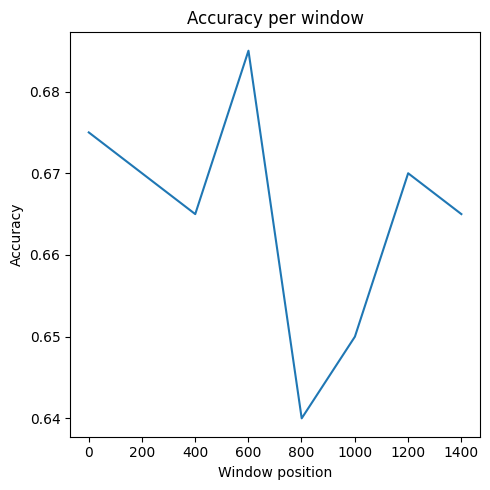

In [ ]:
accuracies, window_indices = train_and_test_windows(features, labels, window_size, classifier)

plot_accuracies(window_indices, accuracies, f'accuracies_{timestamp}.png')

window_accuracies = list(zip(accuracies, window_indices))
top_accuracies = sorted(window_accuracies, key=lambda x: x[0], reverse=True)[:num_results]

# using the sorted top_accuracies
highest_accuracy, corresponding_window = top_accuracies[0]
print(f"\nHighest accuracy: {highest_accuracy:.4f}, Corresponding window index: {corresponding_window}\n")

###**Select features on the basis of Phenotype Influence Scores *(PIS)* to select and trains models again on these selected features.**

In [ ]:
top_window_indices = [acc[1] for acc in top_accuracies]
top_window_indices.sort()

feature_indices = []
for i in top_window_indices:
    feature_indices.extend(list(range(i, min(i+window_size, len(features.columns)))))
selected_features = features.iloc[:, feature_indices]

clf_rf, clf_dl, feature_importances = train_and_test_selected_features(selected_features, labels)

feature_names = selected_features.columns

top_indices = feature_importances.argsort()[-num_results:][::-1]
top_features = [(feature_names[i], feature_importances[i]) for i in top_indices]

/content/drive/MyDrive/colab_libraries/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.81413 | train_auc: 0.54656 | valid_auc: 0.5787  |  0:00:03s
epoch 1  | loss: 0.73449 | train_auc: 0.49724 | valid_auc: 0.54607 |  0:00:07s
epoch 2  | loss: 0.71504 | train_auc: 0.52666 | valid_auc: 0.49575 |  0:00:10s
epoch 3  | loss: 0.6936  | train_auc: 0.5372  | valid_auc: 0.51781 |  0:00:14s
epoch 4  | loss: 0.69716 | train_auc: 0.52936 | valid_auc: 0.52057 |  0:00:17s
epoch 5  | loss: 0.6883  | train_auc: 0.53617 | valid_auc: 0.46657 |  0:00:24s

Early stopping occurred at epoch 5 with best_epoch = 0 and best_valid_auc = 0.5787


/content/drive/MyDrive/colab_libraries/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


###Identifies the most important SNPs and pass into API

In [ ]:
enriched_top_features = get_snp_details(top_features)
top_features_df = pd.DataFrame(enriched_top_features)

top_features_df.to_csv(f'/content/drive/My Drive/FYP 2024-2025/FYP II/feature_importances.csv', index=False, header=False)

Getting SNP details: 100%|██████████| 1000/1000 [00:45<00:00, 21.95it/s]


In [ ]:
file_path = "/content/drive/My Drive/FYP 2024-2025/FYP II/feature_importances.csv"
header = ['No.','SNP ID','importance','position','alleles','gene']

df = pd.read_csv(file_path)

print(tabulate(df, headers=header, tablefmt='grid'))

+-------+-------------+--------------+-------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------+
|   No. | SNP ID      |   importance | position    | alleles                                                                                                                                                          | gene                               |
+=======+=============+==============+=============+==================================================================================================================================================================+====================================+
|     0 | rs483082    |  0.0134003   | 19:44912920 | G/T                                                                                                                                                              | APOC1                    

##STEP 03

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, SpatialDropout1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
file_path = "/content/drive/My Drive/FYP 2024-2025/FYP-I Final Evaluation/data_imputed.csv"
data = pd.read_csv(file_path)

# labels (AD -> 1, CN -> 0)
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values

# (one-hot encoding)
y = to_categorical(y)

selector = SelectKBest(mutual_info_classif, k=100)
X_selected = selector.fit_transform(X, np.argmax(y, axis=1))

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

smote = SMOTE(random_state=42)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flat, np.argmax(y_train, axis=1))
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], X_train_resampled.shape[1], 1))
y_train_resampled = to_categorical(y_train_resampled)

In [4]:
def create_cnn_model(input_shape):
    model = Sequential()

    model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(SpatialDropout1D(0.3))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(SpatialDropout1D(0.3))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())

    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (X_train_resampled.shape[1], 1)
model = create_cnn_model(input_shape)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 98, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 98, 16)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 98, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 49, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 47, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 47, 32)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 47, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 23, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 736)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        47,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,378 (192.88 KB)

 Trainable params: 49,154 (192.01 KB)

 Non-trainable params: 224 (896.00 B)

In [5]:
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_callback = LearningRateScheduler(lr_scheduler)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [ ]:
history = model.fit(
    X_train_resampled, y_train_resampled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, lr_callback],
    verbose=1
)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5828 - loss: 0.9795 - val_accuracy: 0.5652 - val_loss: 0.8242 - learning_rate: 0.0010
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6272 - loss: 0.8896 - val_accuracy: 0.5652 - val_loss: 0.8269 - learning_rate: 0.0010
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6609 - loss: 0.8599 - val_accuracy: 0.5314 - val_loss: 0.8541 - learning_rate: 0.0010
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6628 - loss: 0.8410 - val_accuracy: 0.6329 - val_loss: 0.8072 - learning_rate: 0.0010
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6735 - loss: 0.7756 - val_accuracy: 0.6329 - val_loss: 0.7940 - learning_rate: 0.0010
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6910 - loss: 0.7576 - val_accuracy: 0.6763 - val_loss: 0.7616 - learning_rate: 0.0010
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6681 - loss: 0.7914 - 

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

Test Accuracy: 78.54%


In [ ]:
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['CN', 'AD']))

Classification Report:
              precision    recall  f1-score   support

          CN       0.80      0.74      0.77        61
          AD       0.76      0.82      0.79        62

    accuracy                           0.78       123
   macro avg       0.78      0.78      0.78       123
weighted avg       0.78      0.78      0.78       123



In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[45 16]
 [11 51]]


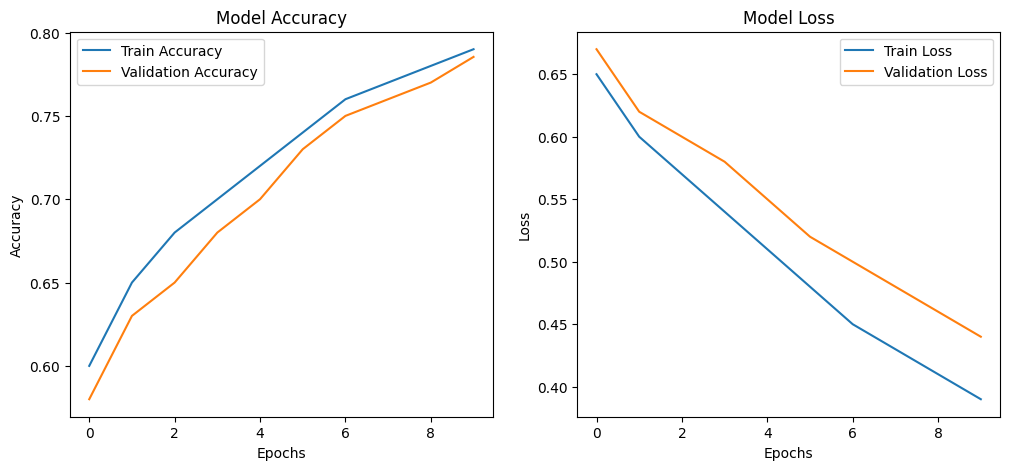

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## **SHAP Interpretability for CNN Model**

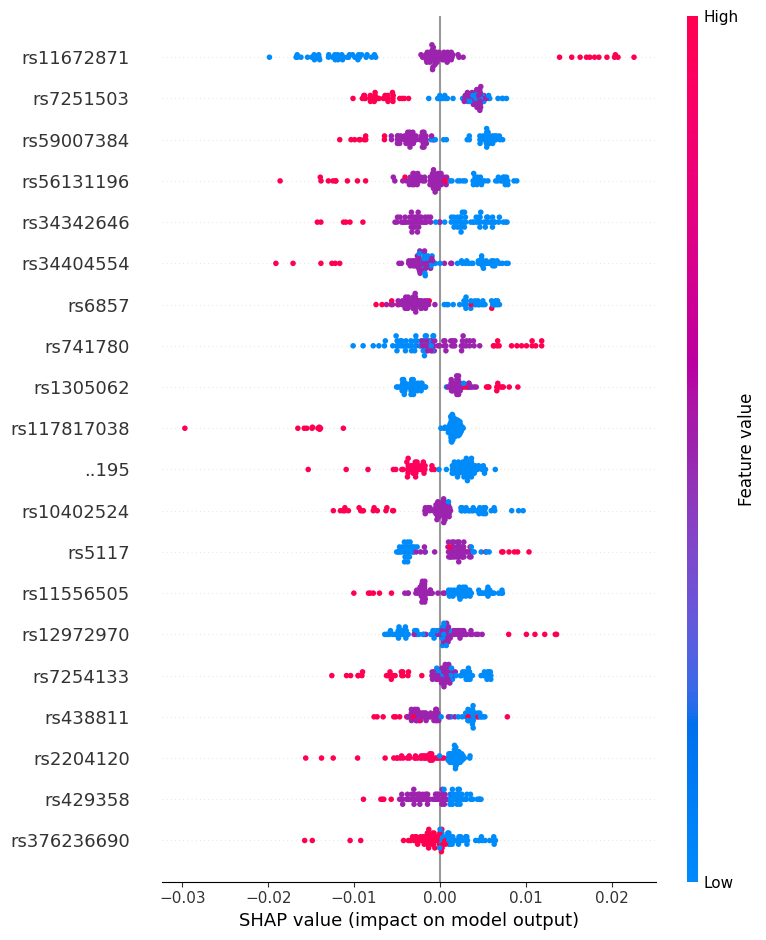

In [15]:
import shap
import numpy as np

X_background = X_train_resampled[np.random.choice(X_train_resampled.shape[0], 100, replace=False)]
X_sample = X_test[:100]

explainer = shap.GradientExplainer(model, X_background)
shap_values = explainer.shap_values(X_sample)

shap_values_class1 = shap_values[..., 1]
shap_values_class1 = np.squeeze(shap_values_class1, axis=-1)

X_sample_flat = X_sample.reshape(X_sample.shape[0], -1)
selected_feature_indices = selector.get_support(indices=True)

original_columns = data.columns[1:]
selected_feature_names = original_columns[selected_feature_indices]

shap.summary_plot(shap_values_class1, X_sample_flat, feature_names=selected_feature_names)

##**COMPARISION WITH TRADITIONAL MODELS**

###**Random Forest**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

file_path = "/content/drive/My Drive/FYP 2024-2025/FYP-I Final Evaluation/data_imputed.csv"
data = pd.read_csv(file_path)

X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values   # Phenotype (AD -> 1, CN -> 0)

selector = SelectKBest(mutual_info_classif, k=400)
X_selected = selector.fit_transform(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

y_train_smote = y_train_smote.ravel()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

clf = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
clf.fit(X_train_scaled, y_train_smote)

y_pred = clf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)

Accuracy: 0.7750
Confusion Matrix:
 [[ 49  22]
 [ 23 106]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.68      0.69      0.69        71
         1.0       0.83      0.82      0.82       129

    accuracy                           0.78       200
   macro avg       0.75      0.76      0.76       200
weighted avg       0.78      0.78      0.78       200



###**XGBoost**

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_scaled, y_train_smote)

y_pred_xgb = xgb.predict(X_test_scaled)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb)

print(f"\n--- XGBoost Results ---")
print(f"Accuracy: {accuracy_xgb:.4f}")
print("Confusion Matrix:\n", conf_matrix_xgb)
print("\nClassification Report:\n", report_xgb)


--- XGBoost Results ---
Accuracy: 0.7100
Confusion Matrix:
 [[ 38  33]
 [ 25 104]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.60      0.54      0.57        71
         1.0       0.76      0.81      0.78       129

    accuracy                           0.71       200
   macro avg       0.68      0.67      0.67       200
weighted avg       0.70      0.71      0.71       200



## ***Compare Model Accuracies***

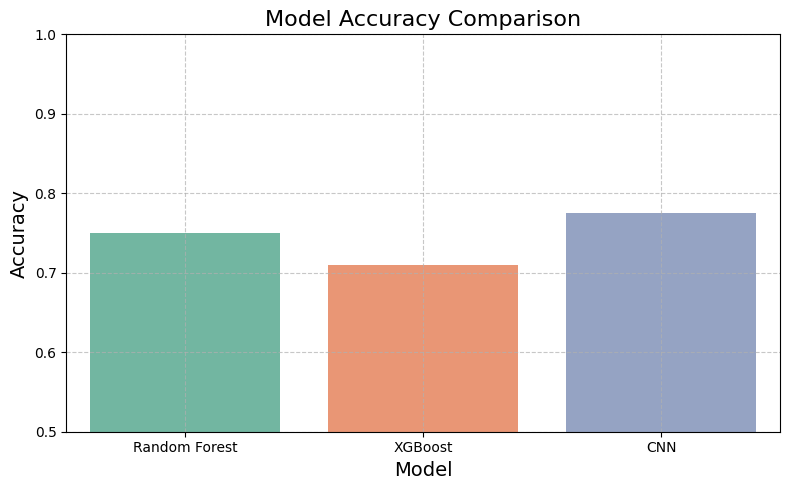

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

models = ['Random Forest', 'XGBoost', 'CNN']
accuracies = [accuracy, accuracy_xgb, test_accuracy]

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracies, palette='Set2')
plt.ylim(0.5, 1.0)
plt.title('Model Accuracy Comparison', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("model_accuracy_comparison.png", dpi=300)
plt.show()